In [52]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [41]:
plot_dir = '../plots/2022-12-13_figures'
save = True

# Gaia DR3 QSO candidate viz

In [33]:
NSIDE = 64
fn_gaia = f'../data/gaia_slim.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
print(f"Number of data sources: {N_data}")
map_nqso, pixel_indices = maps.get_map(NSIDE, tab_gaia['ra'], tab_gaia['dec'], null_val=0)

Number of data sources: 6649162


In [34]:
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")
map_ndens = map_nqso/area_per_pixel

Area per pixel: 0.839 deg


In [35]:
np.min(map_ndens)

0.0

In [36]:
map_ndens_masked = hp.ma(map_ndens)
map_ndens_masked.mask = map_ndens==0

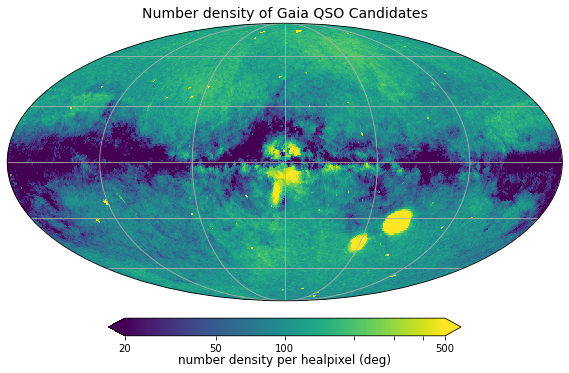

In [42]:
projview(map_ndens_masked, title=rf"Number density of Gaia QSO Candidates",
            unit=r"number density per healpixel (deg)", cmap='viridis', coord=['C', 'G'], 
            min=20, max=500, norm='log', graticule=True,
           show_tickmarkers=True, cbar_ticks=[20, 50, 100, 500])

fn = f'{plot_dir}/gaia_qso_candidates_2d.png'
if save:
    plt.savefig(fn)

# Color cuts

In [43]:
# TODO: better cuts! 
cut_0 = 0., 1., 0.2
cut_1 = 1., 1., 2.9

def plot_cut(ax, cut):

    xx = np.array(ax.get_xlim())
    yy = np.array(ax.get_ylim())

    if abs(cut[0]) > abs(cut[1]):
        ax.plot((cut[2] - cut[1]*yy)/cut[0], yy, 'k-')
    else:
        ax.plot(xx, (cut[2] - cut[0]*xx)/cut[1], 'k-')
        
    ax.set_xlim(xx)
    ax.set_ylim(yy)

def cut_index(g_w1, w1_w2, cut):
    return cut[0] * g_w1 + cut[1] * w1_w2 > cut[2]

In [45]:
fn_sdss_full = '../data/SDSS_DR16Q_v4.fits'
tab_sdss_full = Table.read(fn_sdss_full, format='fits')

In [47]:
g_sdss = tab_sdss_full['GAIA_G_MAG']
w1_sdss = tab_sdss_full['W1_MAG']
w2_sdss = tab_sdss_full['W2_MAG']

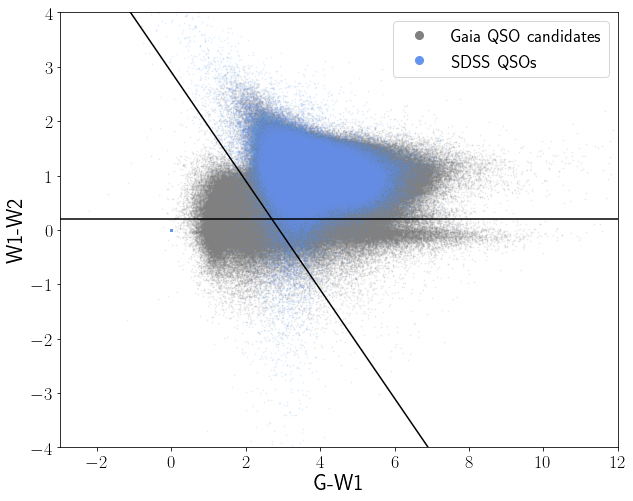

In [57]:
plt.figure(figsize=(10,8))

colors = ['grey', 'cornflowerblue']
labels = ['Gaia QSO candidates', 'SDSS QSOs']
plt.scatter(tab_gaia['g_w1'], tab_gaia['w1_w2'], color=colors[0], s=1, alpha=0.1, label=labels[0])
plt.scatter(g_sdss-w1_sdss, w1_sdss-w2_sdss, color=colors[1], s=1, alpha=0.1, label=labels[1])

#for i in range(len(tables)):
    #g_w1, w1_w2, g, w1, w2 = get_gaia_wise_colors(tables[i], key_mode=None)
    #plt.scatter(g_w1, w1_w2, s=1, alpha=0.1, color=colors[i], label=labels[i], zorder=zorders[i])

ax = plt.gca()
plot_cut(ax, cut_0)
plot_cut(ax, cut_1)

plt.xlim(-3, 12)
plt.ylim(-4,4)
plt.xlabel('G-W1')
plt.ylabel('W1-W2')

legend_elements_markers = [Line2D([0], [0], marker='o', color=colors[i], label=labels[i],
                          markersize=8, ls='None') for i in range(len(colors))]

plt.legend(handles=legend_elements_markers, loc='upper right')

TODO: issue with zeros seen on plot for SDSS. what to do?